## Notebook to analyze single PLQY measurements.  
In local directory: 
Place reference files named PowerCurrent_Averaged.csv, SQ.csv, Detector_Responsivity.csv. 
Place raw data into local directory titled "Data". 

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from natsort import natsorted
from tqdm import tqdm
import seaborn as sns
plus_minus = u"\u00B1"

Define functions for analyis:

In [2]:
def calc_plqy_deMello(data: pd.DataFrame, sample_wl: float, sample_resp: float, laser_wl: float, laser_resp: float):

    """A function to calculate the PLQY based in a publication by de Mello et al.
       The most widely used method for calculating PLQY.
       https://doi.org/10.1002/adma.19970090308

    Args:
        data (pd.DataFrame): dataframe loaded in using the load_plqy() function
        sample_wl (float): the peak emission wavelength of the sample
        sample_resp (float): the responsivity of the detector at sample_wl
        laser_wl (float): the emission wavelength of the laser. Probably 532.0nm
        laser_resp (float): the responsivity of the detector at the laser_wl

    Returns:
        tuple: (PLQY, PLQY error), resported as fractional, not percentage
    """

    E_in = data['in_lp'].mean()
    E_in_err = data['in_lp'].std()/E_in

    E_out = data['out_lp'].mean()
    E_out_err = data['out_lp'].std()/E_out

    X_in = data['in_nolp'].mean() 
    X_in_err = (data['in_nolp'].std()/X_in) 

    X_out = data['out_nolp'].mean() 
    X_out_err = (data['out_nolp'].std()/X_out) 

    X_empty = data['empty_nolp'].mean() 
    X_empty_err = (data['empty_nolp'].std()/data['empty_nolp'].mean()) 

    E_in = E_in*(sample_wl/sample_resp)
    E_out = E_out*(sample_wl/sample_resp)

    X_in = X_in*(laser_wl/laser_resp)
    X_out = X_out*(laser_wl/laser_resp)
    X_empty = X_empty*(laser_wl/laser_resp)

    a = (X_out-X_in)/X_out
    a_err = np.sqrt(((X_out_err + X_in_err)**2) + (X_out_err**2))

    plqy = (E_in-(1-a)*E_out)/(X_empty*a)
    plqy_err = np.sqrt((E_in_err**2) + ((E_out_err + a_err)**2) + (X_empty_err**2))

    return plqy, plqy_err*plqy


def get_responsivity(emission_wl):
    resp = pd.read_csv('Detector_Responsivity.csv')
    return float(resp['Responsivity'][resp['Wavelength'] == emission_wl])

Load in data  

In [3]:
# load in the power reference and index by the currents rounded to the first decimal place
ref = pd.read_csv('PowerCurrent_Averaged.csv', index_col='currents')
ref.index = np.round(ref.index, decimals = 1)

# load in the SQ limit dataframe
sq = pd.read_csv('SQ.csv', index_col='Eg')

# Define the directory containing the CSV files
directory = "data"

# Initialize an empty dictionary to store the dataframes
raw_data = {}

# Initialize an empty list to store the sample names
sample_names = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Construct the full file path
        file_path = os.path.join(directory, filename)

        # Read the CSV file and store it in the dictionary
        # The key is the filename without the .csv extension
        dataframe_name = filename[:-4]
        raw_data[dataframe_name] = pd.read_csv(file_path)

        # Add the name (without the .csv extension) to the sample_names list
        sample_names.append(dataframe_name)

# Sort the sample names
sample_names = natsorted(sample_names)
currents = {}
data = {}

Modify EMISSION_WL value dependent on bandgap/PL spectra

In [4]:
EMISSION_WL = 808 #nm, modify this based on bandgap
LASER_WL = 532 #nm
LASER_SPOT_SIZE = 0.066 #cm^2, roughly estimated
kT = 0.026 #eV
REFLECTION_LOSSES = 0.08 # fraction of 1 taken off of the Jsc to make implied curve more real
bandgap =  np.round(1240/EMISSION_WL, 2) #ev

EMISSION_RESP = get_responsivity(EMISSION_WL)
LASER_RESP = get_responsivity(LASER_WL)

Calculate PLQY and populate data dictionary dataframes with values

In [5]:
for n in sample_names:
    # Extract the last three characters (assumed to be numbers) from the sample name
    # and convert them to float, then round to one decimal place
    current_value = np.round(float(n[-3:]), decimals=1)

    # Initialize a sub-dictionary for each sample
    data[n] = {}
    data[n]['powers'] = ref.at[current_value, 'power'] * 1000  # Convert watts to mW

    # Now apply the calc_plqy_deMello function to the DataFrame of the current sample
    plqy, plqy_err = calc_plqy_deMello(raw_data[n], EMISSION_WL, EMISSION_RESP, LASER_WL, LASER_RESP)
    
    # Storing the PLQY results in the data dictionary for the current sample
    data[n]['plqy'] = plqy
    data[n]['plqy_err'] = plqy_err
    data[n]['Eg'] = bandgap
    data[n]['Voc_rad'] = sq['Voc'][data[n]['Eg']]
    data[n]['Jsc_rad'] = sq['Jsc'][data[n]['Eg']]
    data[n]['Suns'] = (data[n]['powers'] / LASER_SPOT_SIZE) / sq['laser power'][data[n]['Eg']]
    data[n]['qfls'] = data[n]['Voc_rad'] + kT * np.log(data[n]['Suns'] * data[n]['plqy'])
    data[n]['qfls_err'] = kT * np.log(1 + data[n]['plqy_err'] / data[n]['plqy'])
    data[n]['qfls_rad'] = data[n]['Voc_rad'] + kT * np.log(data[n]['Suns'])

Set your color palette to your preference

In [6]:
colors = sns.set_palette('Set2')

Plot PLQY

In [7]:
def plot_plqy(save=False):
    plt.figure(figsize=(8,6), dpi=600)
    for i, n in enumerate(sample_names):
        y = data[n]['plqy']
        y_err = data[n]['plqy_err']
        plt.bar(x = i, height = y, yerr = y_err, label = n, capsize = 5, color = colors)

    plt.xticks(ticks = np.arange(len(sample_names)), labels = sample_names)
    plt.yscale('log')
    plt.ylim(1e-4, 1)
    plt.legend()
    plt.ylabel('PLQY')
    plt.title('PLQY')
    if save: 
        plt.savefig('PLQY.png', dpi=600)

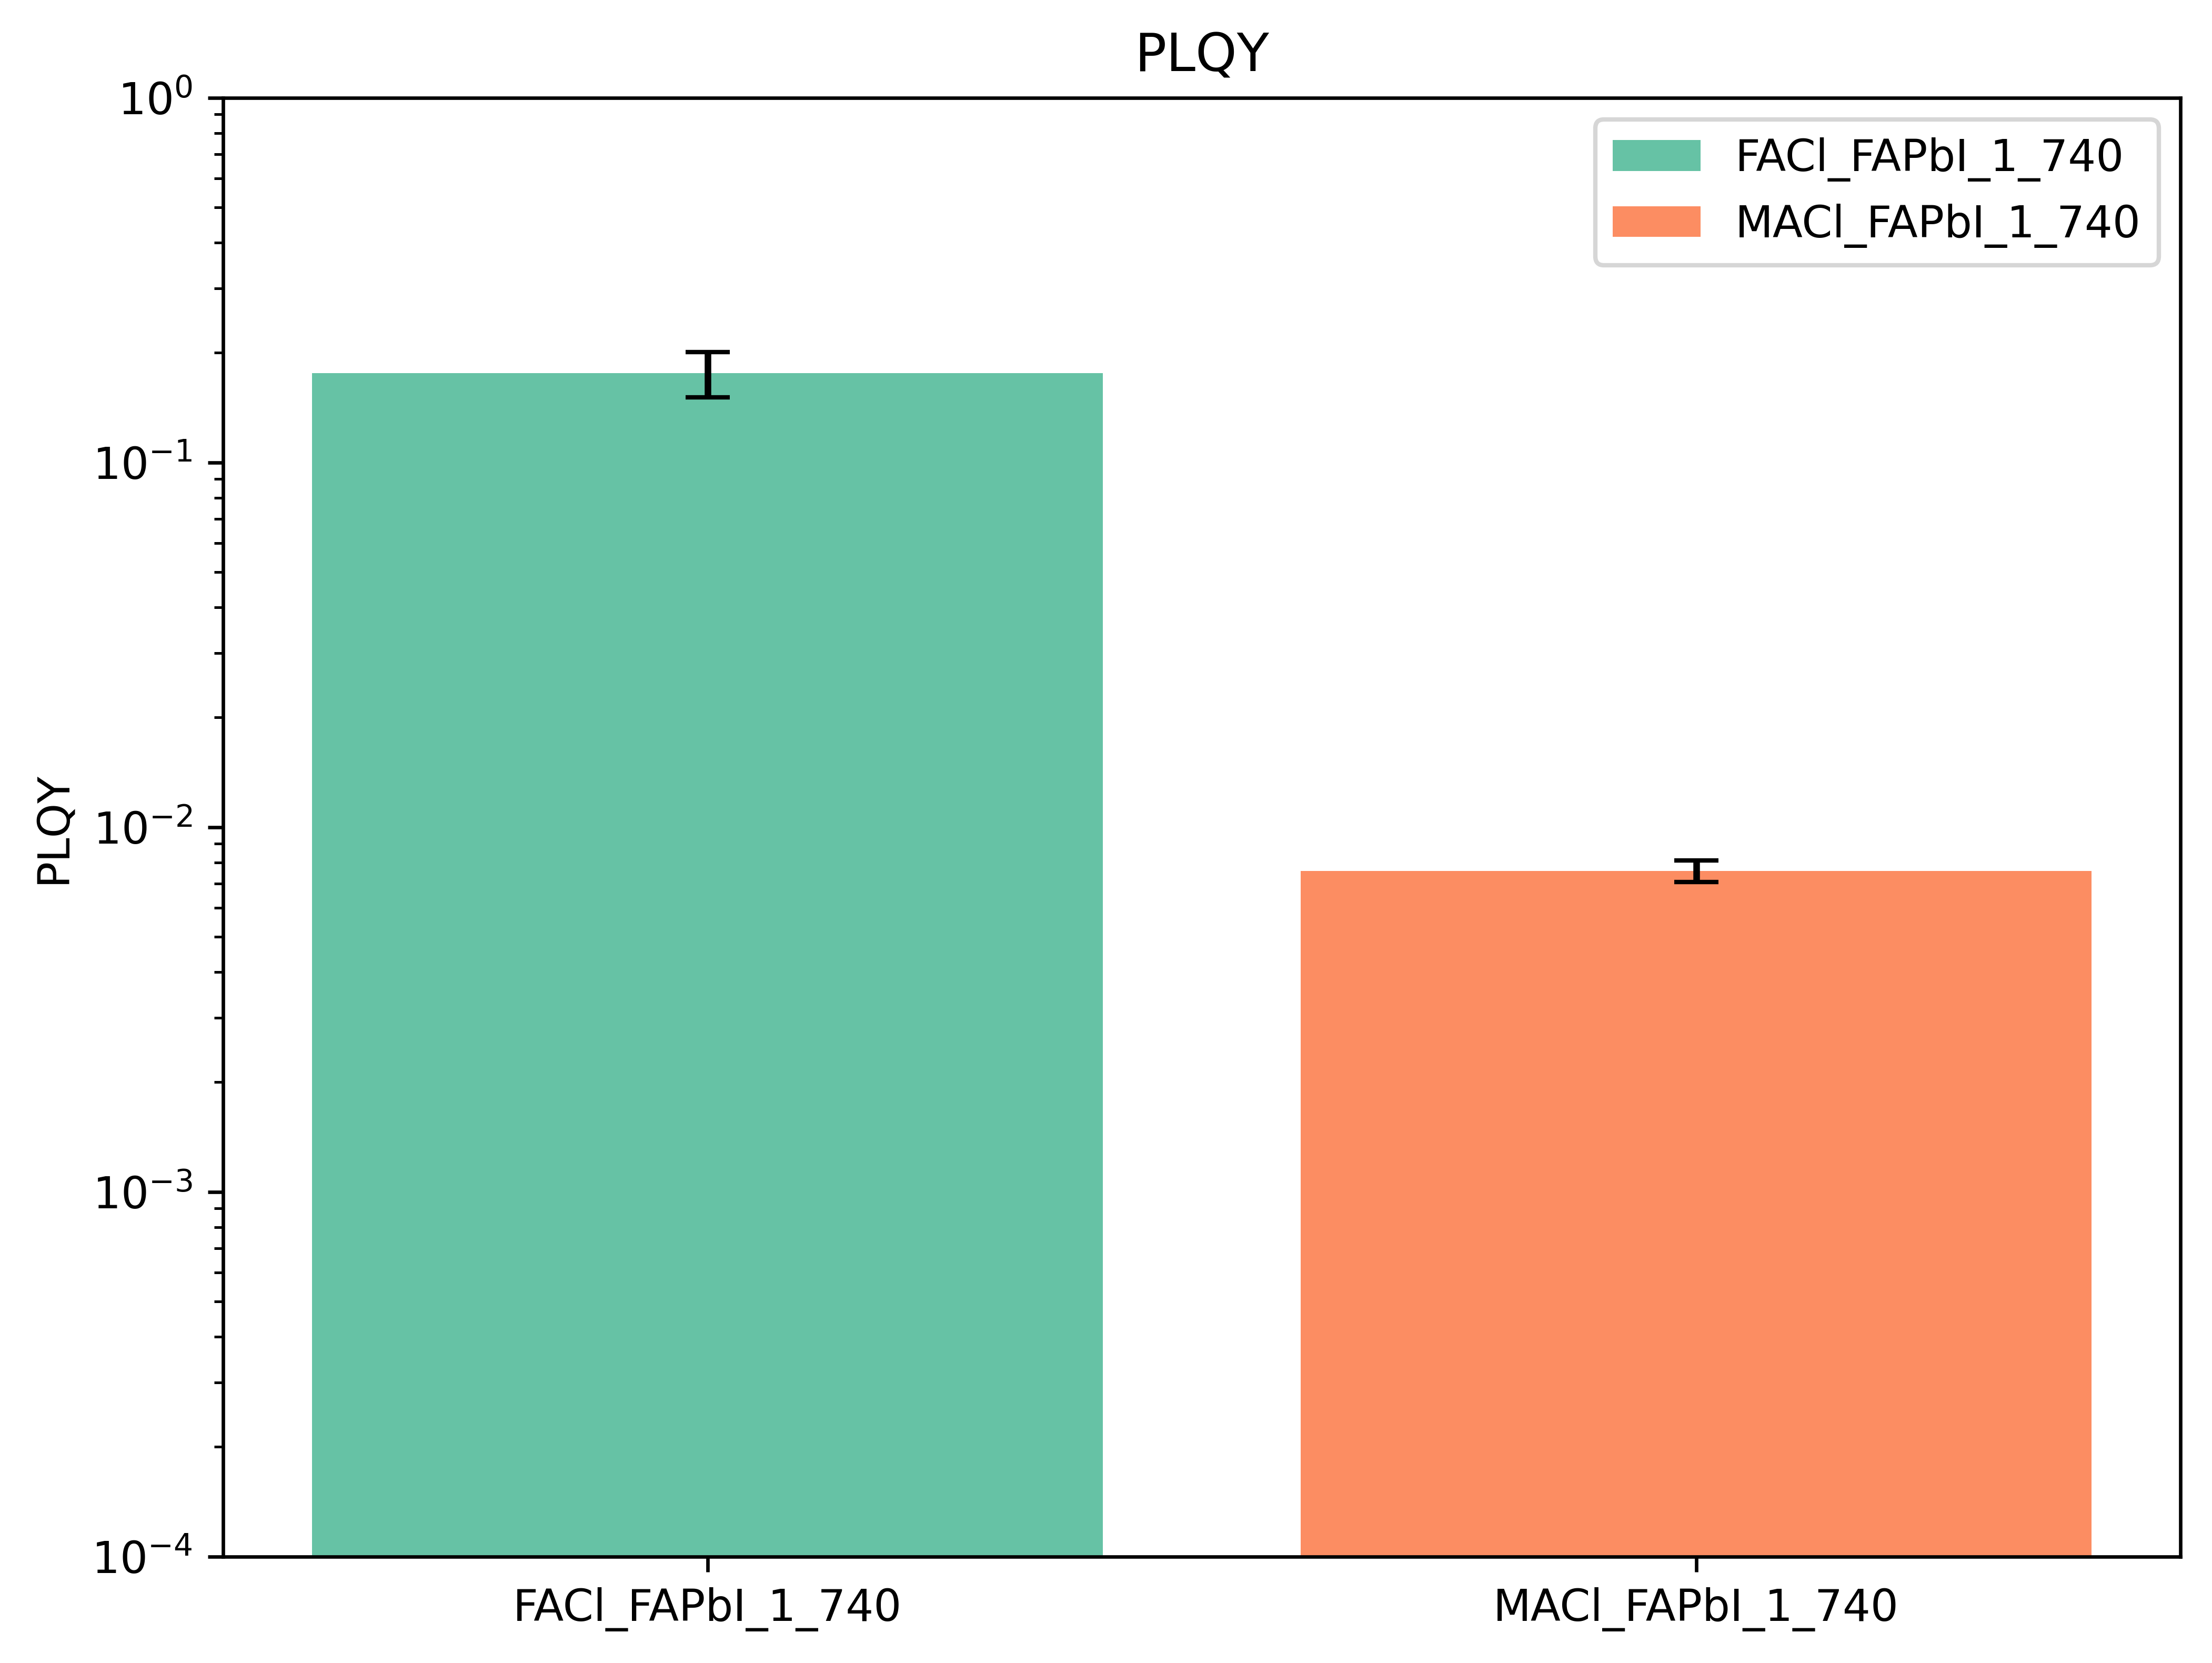

In [8]:
plot_plqy(save=True)

Plot QFLS/ Implied Voltage

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_qfls(save=False):
    plt.figure(figsize=(8, 6), dpi=600)

    # Assuming the detailed balance limit is the same for all samples
    rad_limit = data[next(iter(sample_names))]['qfls_rad']

    # Plot the dashed line for the detailed balance limit
    plt.axhline(y=rad_limit, color='gray', linestyle='--', label='Detailed balance limit')

    for i, n in enumerate(sample_names):
        y = data[n]['qfls']
        y_err = data[n]['qfls_err']
        plt.bar(x=i, height=y, yerr=y_err, capsize=5, color=colors)

    # Set the x-ticks to correspond to the sample names
    plt.xticks(ticks=np.arange(len(sample_names)), labels=sample_names)
    plt.ylim(rad_limit/2, rad_limit*1.05)
    plt.ylabel('QFLS (V)')
    plt.title('QFLS')
    plt.legend()
    if save:
        plt.savefig('QFLS.png', dpi=600)

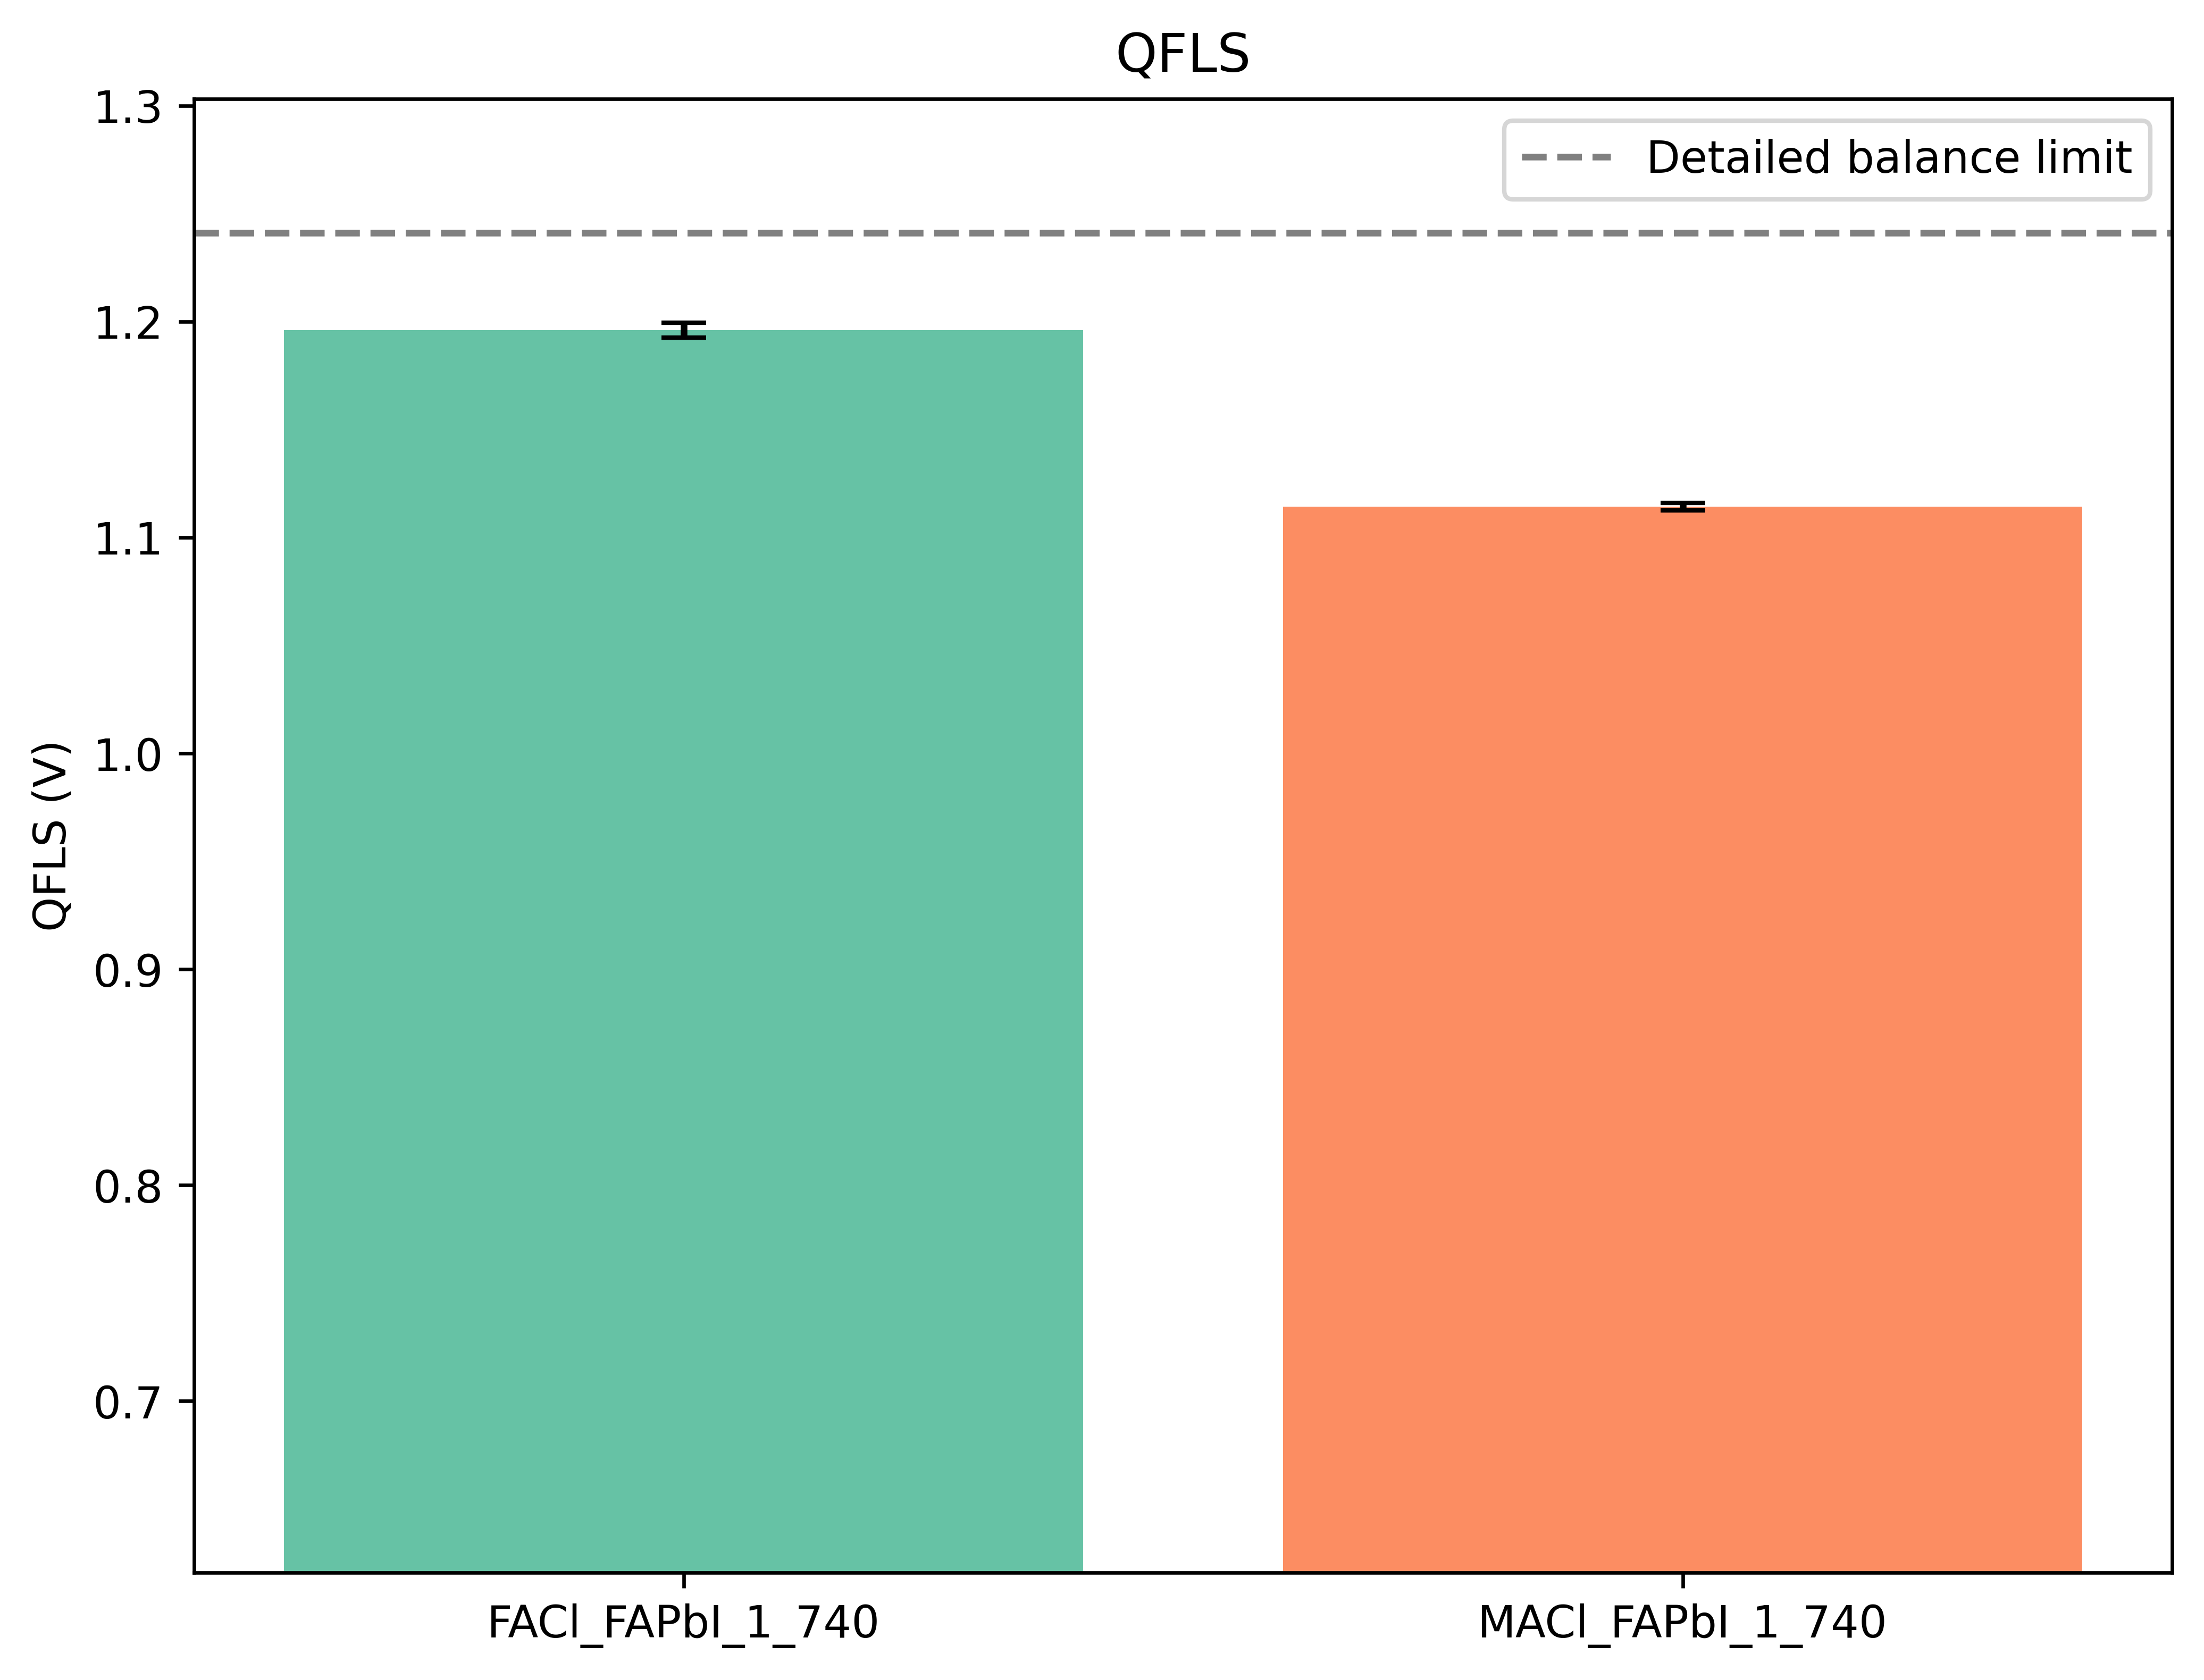

In [10]:
# Call the function to plot
plot_qfls(save=True)